In [1]:
# torch 
import torch

# utils
import os
import numpy as np
import argparse

# statistics & visualization
import matplotlib.pyplot as plt

# model & dataset
from model.densenet_3d import DenseNet3D
from dataset import dataset

# evaluation
from metric.WER_CER_metric import CalculateErrorRate
from misc import idx2text, ctc_decoder, plot_error_curves_comparison

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description='Lip Reading')
    parser.add_argument('--batch_size', type=int, default=64, help='batch size')
    parser.add_argument('--epochs', type=int, default=10, help='number of epochs')
    parser.add_argument('--lr', type=float, default=0.0001, help='learning rate')
    parser.add_argument('--num_workers', type=int, default=0, help='number of workers')
    parser.add_argument('--save_dir', type=str, default='./checkpoints', help='save path')
    parser.add_argument('--data', type=str, default='/data/ziruiw3/lip_reading/frames/', help='train data path')
    parser.add_argument('--visualize', type=bool, default=False, help='visualize error curve')

    args = parser.parse_args()
    return args

In [3]:
def evaluate(model, valid_loader, device, epoch, log):
    model.eval()

    with torch.no_grad():
        # initialize
        eval_loss = []
        eval_WER = []
        eval_CER = []
        
        criterion = torch.nn.CTCLoss()

        for _, (video, label, video_length, label_length) in enumerate(valid_loader):
            if video is None:
                continue
            video, label, video_length, label_length = video.to(device), label.to(device), video_length.to(device), label_length.to(device)
            output = model(video)

            # calculate loss
            loss = criterion(output.log_softmax(-1).transpose(0,1), label, video_length.view(-1), label_length.view(-1))
            eval_loss.append(loss.detach().cpu().numpy())

            pred_text = ctc_decoder(output)
            gt_text = []
            for _ in range(len(label)):
                gt_text.append(idx2text(label[_]))
            
            # calculate WER and CER
            wer = CalculateErrorRate(gt_text[0], pred_text[0], method='WER')
            cer = CalculateErrorRate(gt_text[0], pred_text[0], method='CER')
            eval_WER.append(wer)
            eval_CER.append(cer)

            mean_WER = np.mean(np.array(eval_WER))
            mean_CER = np.mean(np.array(eval_CER))
        
        # print statistics
        print('Evaluation Loss: {:.3f}, eval WER: {:.3f}, eval CER: {:.3f}'.format(epoch+1, np.mean(np.array(eval_loss)), mean_WER, mean_CER))
        log.write('Evaluation Loss: {:.3f}, eval WER: {:.3f}, eval CER: {:.3f}\n'.format(epoch+1, np.mean(np.array(eval_loss)), mean_WER, mean_CER))


In [8]:
def train(rnn):
    # prepare log 
    if not os.path.exists('./log'):
        os.makedirs('./log')
    log = open('./log/log.txt', 'a')

    # # parse args
    # args = parse_args()
    # log.write(str(args)+'\n')
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    log.write('Using device: {}\n'.format(device))

    # load data
    train_loader, valid_loader = dataset.get_dataloaders(root_path='/data/ziruiw3/lip_reading/frames/',
                                                         batch_size=64,
                                                         split=0.8,
                                                         shuffle=True,
                                                         num_workers=0,
                                                         pin_memory=False)
    print("data loaded")

    # output directory 
    outputs = {}

    # ---- training 3D CNN + GRU -----
    # load model
    model = DenseNet3D(rnn)
    model.to(device)
    criterion = torch.nn.CTCLoss()                                  # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)    # optimizer
    print("model loaded")
    model.train() 

    # training
    WER = []
    CER = []
    iteration = 0
    print("start training...")

    for epoch in range(10):
        model.train()
        for _, (video, label, video_length, label_length) in enumerate(train_loader):

            if video is None: # some videos have incorrect number of frames, skip them (see collate_fn in dataset.py)
                continue

            # reset gradients
            optimizer.zero_grad()

            # load data to GPU
            video, label,video_length, label_length = video.to(device), label.to(device), video_length.to(device), label_length.to(device)

            # forward 
            output = model(video)   #(T, B, C, H, W) -> (B, T, Emb=28) (n, 75, 28)

            # backward
            loss = criterion(output.log_softmax(-1).transpose(0,1), label, video_length.view(-1), label_length.view(-1))
            loss.backward()

            # decode text output
            pred_text = ctc_decoder(output)

            gt_text = []
            for _ in range(len(label)):
                gt_text.append(idx2text(label[_]))

            # calculate WER and CER
            wer = CalculateErrorRate(gt_text[0], pred_text[0], method='WER')
            cer = CalculateErrorRate(gt_text[0], pred_text[0], method='CER')
            WER.append(wer)
            CER.append(cer)


            mean_WER = np.mean(np.array(WER))
            mean_CER = np.mean(np.array(CER))

            # update parameters
            optimizer.step()

            # statistics
            iteration += 1
            if iteration % 50 == 0:
                # print statistics and write to log
                print('Epoch [{}/{}], Iteration: {}, Loss: {:.3f}, WER: {:.3f}, CER: {:.3f}'.format(epoch + 1, 10, iteration, loss.item(), mean_WER, mean_CER))
                log.write('Epoch [{}/{}], Iteration: {}, Loss: {:.3f}, WER: {:.3f}, CER: {:.3f}\n'.format(epoch + 1, 10, iteration, loss.item(), mean_WER, mean_CER))

        # validation after each epoch
        evaluate(model, valid_loader, device, epoch,log)

        # save model
        if not os.path.exists("./checkpoints"):
            os.makedirs("./checkpoints")
        torch.save(model.state_dict(), os.path.join("./checkpoints", 'densenet3d-gru-ep{}.pth'.format(epoch)))

        # flush log
        log.flush()
    
    return WER, CER

In [9]:
outputs = {}
gru_WER, gru_CER = train('gru')  
outputs.update({'gru': {'train_wer': gru_WER, 'train_cer': gru_CER}})


data loaded
model loaded
start training...
Epoch [1/10], Iteration: 50, Loss: 2.843, WER: 1.000, CER: 1.075
Epoch [1/10], Iteration: 100, Loss: 2.676, WER: 0.998, CER: 1.019
Epoch [1/10], Iteration: 150, Loss: 2.529, WER: 0.999, CER: 0.977
Epoch [1/10], Iteration: 200, Loss: 2.436, WER: 0.999, CER: 0.948
Epoch [1/10], Iteration: 250, Loss: 2.362, WER: 0.999, CER: 0.927
Epoch [1/10], Iteration: 300, Loss: 2.286, WER: 0.999, CER: 0.912
Epoch [1/10], Iteration: 350, Loss: 2.152, WER: 1.000, CER: 0.901
Epoch [1/10], Iteration: 400, Loss: 2.074, WER: 0.998, CER: 0.888
Epoch 1 Evaluation Loss: 2.013, eval WER: 0.989, eval CER: 0.801
Epoch [2/10], Iteration: 450, Loss: 1.995, WER: 0.997, CER: 0.879
Epoch [2/10], Iteration: 500, Loss: 1.888, WER: 0.997, CER: 0.865
Epoch [2/10], Iteration: 550, Loss: 1.808, WER: 0.997, CER: 0.853
Epoch [2/10], Iteration: 600, Loss: 1.684, WER: 0.997, CER: 0.842
Epoch [2/10], Iteration: 650, Loss: 1.633, WER: 0.997, CER: 0.834
Epoch [2/10], Iteration: 700, Loss:

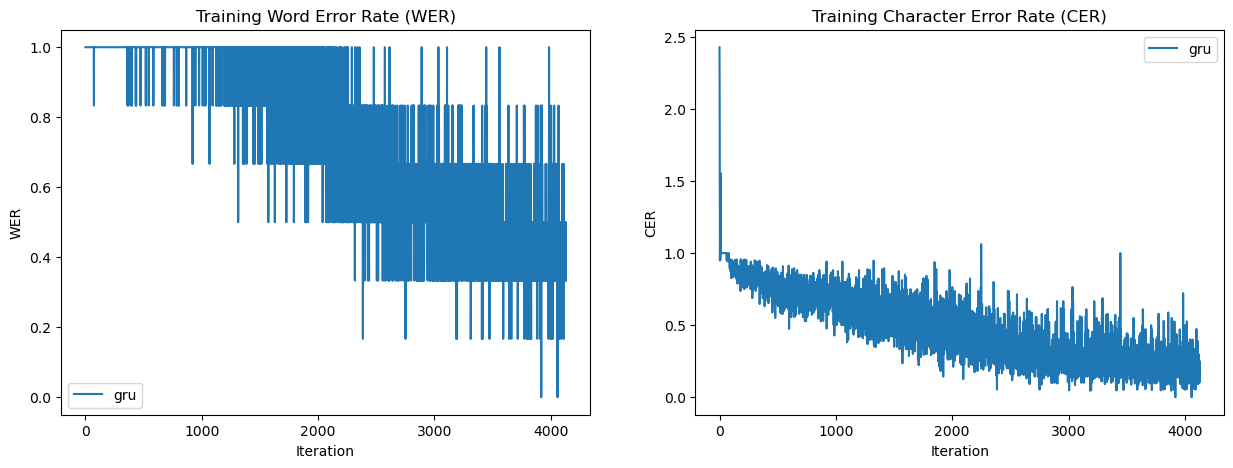

In [10]:
plot_error_curves_comparison(outputs)

In [11]:
Lstm_WER, Lstm_CER = train('lstm')
outputs.update({'lstm': {'train_wer': Lstm_WER, 'train_cer': Lstm_CER}})

data loaded
model loaded
start training...
Epoch [1/10], Iteration: 50, Loss: 2.878, WER: 1.000, CER: 1.063
Epoch [1/10], Iteration: 100, Loss: 2.785, WER: 1.000, CER: 1.032
Epoch [1/10], Iteration: 150, Loss: 2.706, WER: 1.000, CER: 1.017
Epoch [1/10], Iteration: 200, Loss: 2.611, WER: 0.999, CER: 0.997
Epoch [1/10], Iteration: 250, Loss: 2.489, WER: 0.999, CER: 0.982
Epoch [1/10], Iteration: 300, Loss: 2.351, WER: 0.999, CER: 0.965
Epoch [1/10], Iteration: 350, Loss: 2.259, WER: 1.000, CER: 0.952
Epoch [1/10], Iteration: 400, Loss: 2.140, WER: 0.999, CER: 0.939
Epoch 1 Evaluation Loss: 2.049, eval WER: 1.000, eval CER: 0.861
Epoch [2/10], Iteration: 450, Loss: 2.017, WER: 0.999, CER: 0.929
Epoch [2/10], Iteration: 500, Loss: 1.957, WER: 0.998, CER: 0.920
Epoch [2/10], Iteration: 550, Loss: 1.861, WER: 0.997, CER: 0.909
Epoch [2/10], Iteration: 600, Loss: 1.790, WER: 0.997, CER: 0.899
Epoch [2/10], Iteration: 650, Loss: 1.692, WER: 0.996, CER: 0.888
Epoch [2/10], Iteration: 700, Loss:

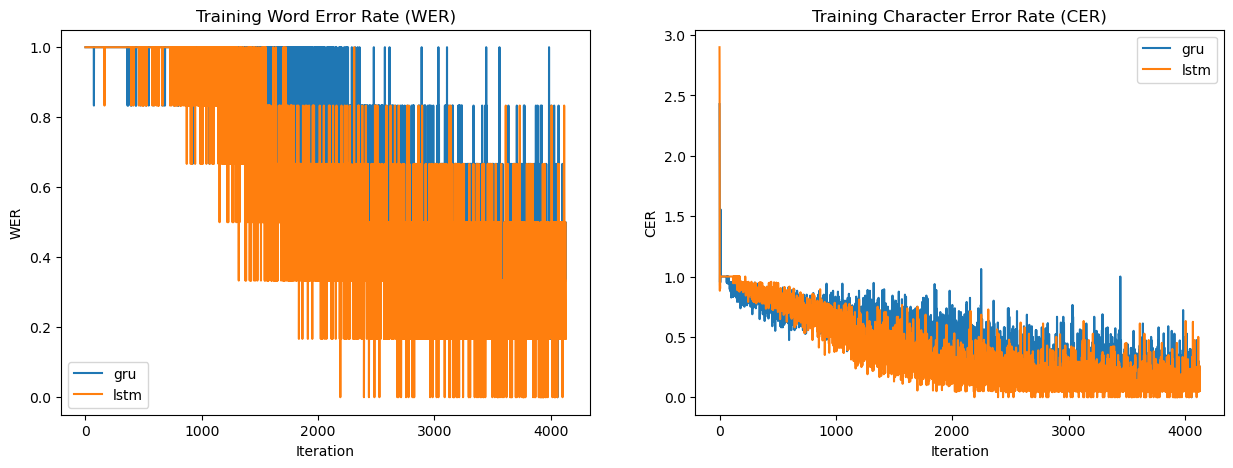

In [12]:
plot_error_curves_comparison(outputs)